<h1><center> Arrival Time Visualization <br><br> 
<center> Differential Privacy Application<br><br> 
Wendy Shi</center></center>

# Table of Content

1. [Load Data](#Load-Data)
2. [Functions](#Functions)
3. [Box plot for arrival time](#Box-plot-for-arrival-time)
4. [Box Plot for Peak Times](#Box-Plot-for-Peak-Times)

# Preparation

In [1]:
#Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import scipy.stats as stats
import statistics

## Population data for each county

In [2]:
ori_mt = pd.read_csv("IL_Data/Aggregate/Il_ori_agg.csv")
ori_mt = ori_mt.drop(columns = 'Unnamed: 0')
ori_mt.head(3)

,17001,17005,17007,17011,17015,17017,17019,17021,17023,17025,...,17185,17187,17189,17191,17193,17195,17197,17199,17201,17203
0,0.844666,0.000223,0.000160,0.000160,0.000000,0.000511,0.000383,0.000096,0.000351,0.001053,...,0.000096,0.000128,0.000096,0.0000,0.0,0.000638,0.007690,0.002617,0.005074,0.000000
1,0.000133,0.298000,0.000000,0.000000,0.000000,0.001467,0.034000,0.012000,0.000133,0.001733,...,0.000000,0.000267,0.000800,0.0028,0.0,0.003733,0.012400,0.016667,0.001733,0.001067
2,0.000000,0.000000,0.403862,0.000105,0.001679,0.000000,0.002624,0.000000,0.000000,0.000000,...,0.000000,0.004723,0.000000,0.0000,0.0,0.004198,0.021935,0.000000,0.158795,0.000000


In [3]:
column_names = ['S', 'E', 'I', 'R']
pop_2020 = pd.read_csv("../../Data/us_shapefile_county.csv")
pop_2020 = pop_2020[['GEO_ID','pop2020']]
pop_2020["GEO_ID"] = pop_2020["GEO_ID"].apply(lambda x: f"{int(x):05d}")

rename = {'GEO_ID':'GEOID'}
pop_2020 = pop_2020.rename(columns = rename)

print(pop_2020.shape)
pop_2020.tail(3)

(3109, 2)


,GEOID,pop2020
3106,06037,9989165.0
3107,46113,14309.0
3108,51515,6599.0


In [4]:
county_list = ori_mt.columns.tolist()
county_pop = pd.DataFrame()
county_pop['GEOID'] = county_list
county_pop.head(3)

,GEOID
0,17001
1,17005
2,17007


In [5]:
# Get list for the population
joined = pd.merge(county_pop, pop_2020, on = 'GEOID', how = 'left')
pop_list = joined['pop2020'].tolist()
print(f'Length of the population list: {len(pop_list)}')
joined.head()

Length of the population list: 86


,GEOID,pop2020
0,17001,65530.0
1,17005,16663.0
2,17007,53326.0
3,17011,33118.0
4,17015,15664.0


# The Loop

## Individual Data

In [6]:
import pickle
with open('IL_Data/Individual/20_simulations_ori_Il_indi.pkl', 'rb') as f:
    ori_data_indi= pickle.load(f)
    
with open('Il_Data/Individual/20_simulations_P8_IL_indi.pkl', 'rb') as f:
    P8_data_indi= pickle.load(f)
    
with open('Il_Data/Individual/20_simulations_P5_IL_indi.pkl', 'rb') as f:
    P5_data_indi= pickle.load(f)
    
with open('IL_Data/Individual/20_simulations_P3_IL_indi.pkl', 'rb') as f:
    P3_data_indi= pickle.load(f)
    
with open('IL_Data/Individual/20_simulations_P1_IL_indi.pkl', 'rb') as f:
    P1_data_indi= pickle.load(f)
    
with open('IL_Data/Individual/20_simulations_P05_IL_indi.pkl', 'rb') as f:
    P05_data_indi= pickle.load(f)
    
with open('IL_Data/Individual/20_simulations_P01_IL_indi.pkl', 'rb') as f:
    P01_data_indi= pickle.load(f)
    
with open('Il_Data/Individual/20_simulations_P005_IL_indi.pkl', 'rb') as f:
    P005_data_indi= pickle.load(f)

## Aggregate Data

In [7]:
import pickle
with open('IL_Data/Aggregate/20_simulations_ori_IL_agg.pkl', 'rb') as f:
    ori_data_agg= pickle.load(f)
    
with open('IL_Data/Aggregate/20_simulations_P5_IL_agg.pkl', 'rb') as f:
    P5_data_agg= pickle.load(f)
    
with open('IL_Data/Aggregate/20_simulations_P1_IL_agg.pkl', 'rb') as f:
    P1_data_agg= pickle.load(f)
    
with open('IL_Data/Aggregate/20_simulations_P05_IL_agg.pkl', 'rb') as f:
    P05_data_agg= pickle.load(f)

with open('IL_Data/Aggregate/20_simulations_P01_IL_agg.pkl', 'rb') as f:
    P01_data_agg= pickle.load(f)

with open('IL_Data/Aggregate/20_simulations_P005_IL_agg.pkl', 'rb') as f:
    P005_data_agg= pickle.load(f)


## Function for optimization

### Arrival_function

In [8]:
#Loop
def arrival_date_list(Df):
    
    #Mean arrival time
    the_86_mean_arrival_ori = []
    Ii_data = pd.DataFrame()
    
    #for each node
    for i in range(86):
        
        #if i % 500 == 0: 
        #print(i)
        
        #For each simulation
        for j in range(20):
            
            #This extract data for the i_th similation
            data = Df[j]
            times, S_values, E_values, I_values, R_values = zip(*data)
            
            #I data for each similation for all node 
            I_list = list(zip(*I_values))
            
            Ii_simu_j = I_list[i] #This specifies we want the i county
            Ii_data[f'simu{j+1}'] = Ii_simu_j
        
        arrival_dates = []
        
        arrival_number = pop_list[i] * 0.001
        
        for n in range(20):
            row_index = Ii_data[Ii_data[f"simu{n+1}"] > arrival_number].index[0]
            arrival_day = row_index + 1
            arrival_dates.append(arrival_day)
            
        mean_arrival = statistics.mean(arrival_dates)
        the_86_mean_arrival_ori.append(mean_arrival)
        
    return(the_86_mean_arrival_ori)

## Peak Dats Function

In [9]:
#Loop
def peak_date_list(Df):
    
    #Mean arrival time
    the_86_mean_peak_ori = []
    Ii_data = pd.DataFrame()
    
    for i in range(86):
        
        #if i % 500 == 0: 
        #    print(i)
        
        #For each simulation
        for j in range(20):
            
            #This extract data for the i_th similation
            data = Df[j]
            times, S_values, E_values, I_values, R_values = zip(*data)
            
            #I data for each similation for all node 
            I_list = list(zip(*I_values))
            
            Ii_simu_j = I_list[i] #This specifies we want the i county
            Ii_data[f'simu{j+1}'] = Ii_simu_j
        
        peak_dates = []
        
        for n in range(20):
            row_index = Ii_data[f"simu{n+1}"].idxmax()
            peak_day = row_index + 1
            peak_dates.append(peak_day)
            
        mean_peak = statistics.mean(peak_dates)
        the_86_mean_peak_ori.append(mean_peak)
        
    return(the_86_mean_peak_ori)

# Apply Function

In [10]:
#Individual Data
mean_arrival_ori_indi = arrival_date_list(ori_data_indi)
mean_arrival_P8_indi = arrival_date_list(P8_data_indi)
mean_arrival_P5_indi = arrival_date_list(P5_data_indi)
mean_arrival_P3_indi = arrival_date_list(P3_data_indi)
mean_arrival_P1_indi = arrival_date_list(P1_data_indi)
mean_arrival_P05_indi = arrival_date_list(P05_data_indi)
mean_arrival_P01_indi = arrival_date_list(P01_data_indi)
mean_arrival_P005_indi = arrival_date_list(P005_data_indi)

In [11]:
#Aggregate
mean_arrival_ori_agg = arrival_date_list(ori_data_agg)
mean_arrival_P5_agg = arrival_date_list(P5_data_agg)
mean_arrival_P1_agg = arrival_date_list(P1_data_agg)
mean_arrival_P05_agg = arrival_date_list(P05_data_agg)
mean_arrival_P01_agg = arrival_date_list(P01_data_agg)
mean_arrival_P005_agg = arrival_date_list(P005_data_agg)

# Box plot for arrival time

In [22]:
#mean_arrival_P8_indi

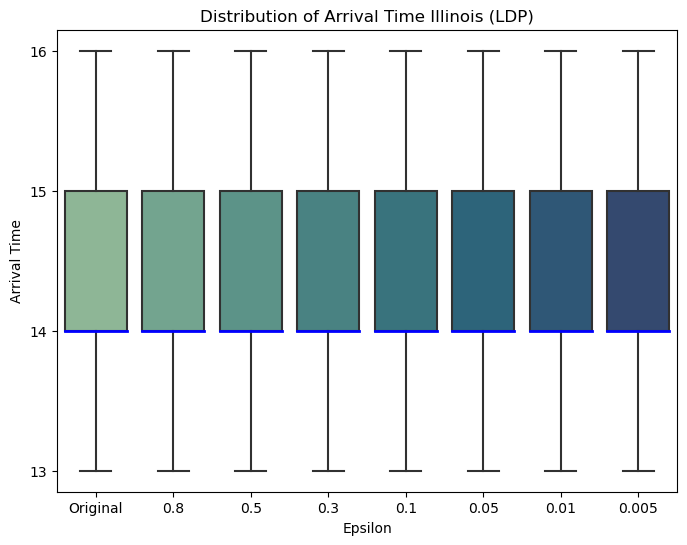

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Combining data into a list of lists
data = [mean_arrival_ori_indi, mean_arrival_P8_indi, mean_arrival_P5_indi, mean_arrival_P3_indi, 
        mean_arrival_P1_indi, mean_arrival_P05_indi, mean_arrival_P01_indi, mean_arrival_P005_indi]

color = sns.color_palette("crest", n_colors =8)

# Plotting with Seaborn
fig, ax = plt.subplots(figsize=(8, 6))
#plt.figure(figsize=(8, 6))
sns.boxplot(data = data, 
            palette=color, 
            saturation= 0.7,
            showfliers=False, 
            ax = ax,
            medianprops=dict(color='blue', linewidth=2))

# Force y-axis to use integers
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Adding labels and title
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['Original', '0.8', '0.5', '0.3', '0.1', 
                                      '0.05', '0.01', '0.005'])
plt.title("Distribution of Arrival Time Illinois (LDP)")
plt.ylabel("Arrival Time")
plt.xlabel("Epsilon")

# Save plot
plt.savefig("arrival_time_box_indi_IL.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


## Aggregate Data

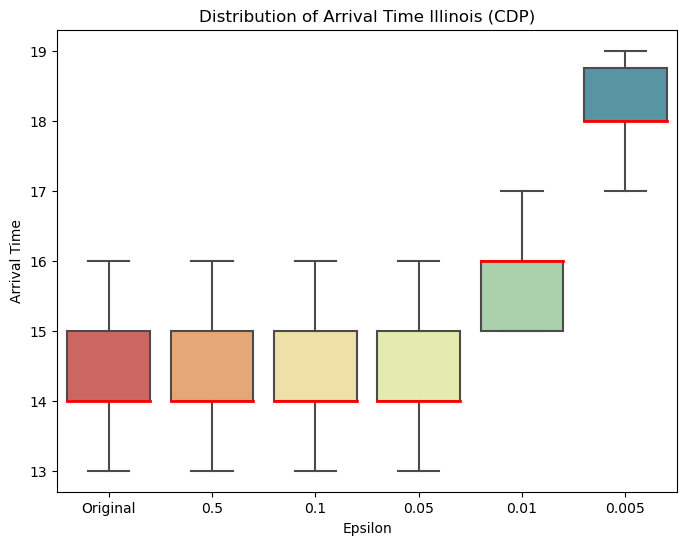

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combining data into a list of lists
data = [mean_arrival_ori_agg, mean_arrival_P5_agg, mean_arrival_P1_agg, mean_arrival_P05_agg,
        mean_arrival_P01_agg, mean_arrival_P005_agg]

#color = sns.color_palette("crest", n_colors =8)
color = sns.color_palette("Spectral", n_colors =6)

# Plotting with Seaborn
#fig, ax = plt.subplots(figsize=(8, 6))
plt.figure(figsize=(8, 6))
sns.boxplot(data = data, palette=color, saturation= 0.7,showfliers=False, medianprops=dict(color='red', linewidth=2))

# Adding labels and title
plt.xticks([0, 1, 2, 3, 4, 5], ['Original', '0.5', '0.1', '0.05', 
                                   '0.01', '0.005'])
plt.title("Distribution of Arrival Time Illinois (CDP)")
plt.ylabel("Arrival Time")
plt.xlabel("Epsilon")

# Save plot
plt.savefig("arrival_time_box_agg_IL.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


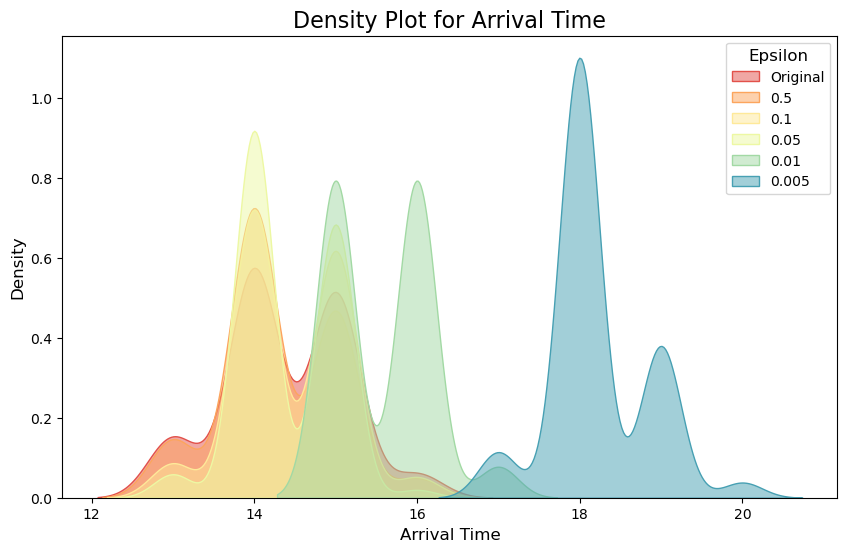

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combining data into a list of lists
data = [mean_arrival_ori_agg, mean_arrival_P5_agg, mean_arrival_P1_agg, mean_arrival_P05_agg,
        mean_arrival_P01_agg, mean_arrival_P005_agg]

labels = ['Original', '0.5', '0.1', '0.05', '0.01', '0.005']

# Generate a color palette
color = sns.color_palette("Spectral", n_colors =6)

# Plotting with Seaborn
plt.figure(figsize=(10, 6))

# Loop through datasets to plot their density
for i, dataset in enumerate(data):
    sns.kdeplot(dataset, label=labels[i], color=color[i], fill=True, alpha=0.5)

# Adding labels and title
plt.title("Density Plot for Arrival Time", fontsize=16)
plt.xlabel("Arrival Time", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Adding a legend
plt.legend(title="Epsilon", fontsize=10, title_fontsize=12)

# Save plot (optional)
#plt.savefig("arrival_time_density.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


# Box Plot for Peak Times

In [31]:
#Individual Data
mean_peak_ori_indi = peak_date_list(ori_data_indi)
mean_peak_P8_indi = peak_date_list(P8_data_indi)
mean_peak_P5_indi = peak_date_list(P5_data_indi)
mean_peak_P3_indi = peak_date_list(P3_data_indi)
mean_peak_P1_indi = peak_date_list(P1_data_indi)
mean_peak_P05_indi = peak_date_list(P05_data_indi)
mean_peak_P01_indi = peak_date_list(P01_data_indi)
mean_peak_P005_indi = peak_date_list(P005_data_indi)

In [33]:
#Aggregate Data
mean_peak_ori_agg = peak_date_list(ori_data_agg)
mean_peak_P5_agg = peak_date_list(P5_data_agg)
mean_peak_P1_agg = peak_date_list(P1_data_agg)
mean_peak_P05_agg = peak_date_list(P05_data_agg)
mean_peak_P01_agg = peak_date_list(P01_data_agg)
mean_peak_P005_agg = peak_date_list(P005_data_agg)

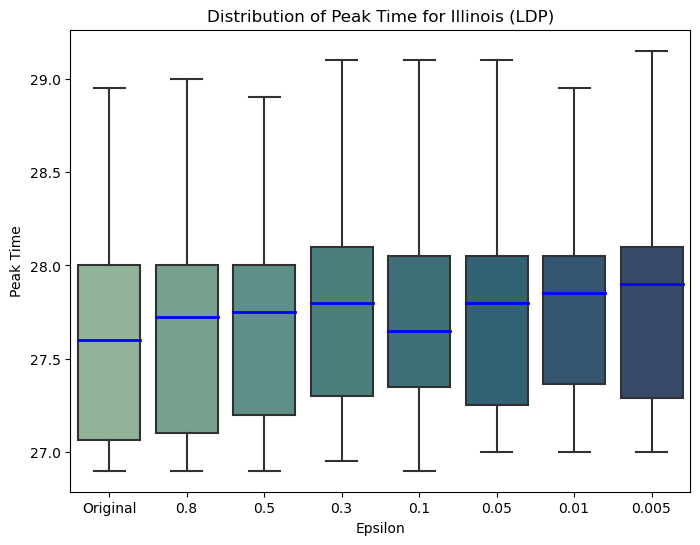

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combining data into a list of lists
data = [mean_peak_ori_indi, mean_peak_P8_indi, mean_peak_P5_indi, mean_peak_P3_indi,
        mean_peak_P1_indi, mean_peak_P05_indi, mean_peak_P01_indi, mean_peak_P005_indi]

color = sns.color_palette("crest", n_colors =8)

# Plotting with Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, 
            palette=color, 
            saturation=0.6, 
            showfliers=False, 
            medianprops=dict(color='blue', linewidth=2))

# Adding labels and title
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['Original', '0.8', '0.5', '0.3', '0.1', '0.05', '0.01', '0.005'])
plt.title("Distribution of Peak Time for Illinois (LDP)")
plt.ylabel("Peak Time")
plt.xlabel("Epsilon")

# Save plot
plt.savefig("peak_time_box_indi_IL.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


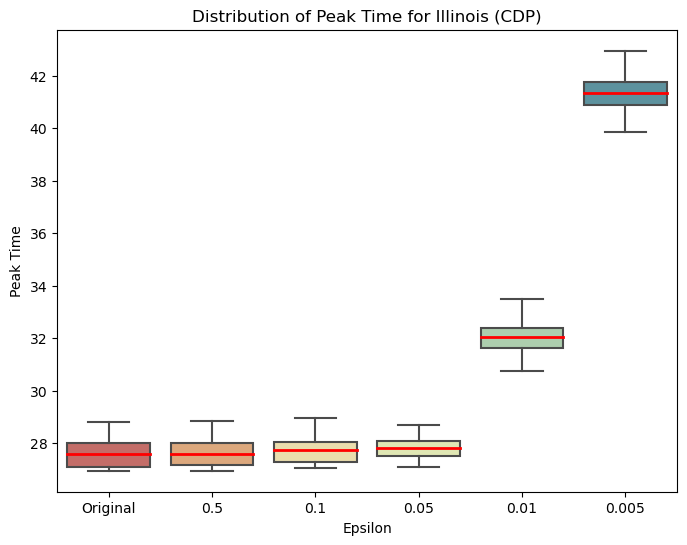

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combining data into a list of lists
data = [mean_peak_ori_agg, mean_peak_P5_agg, mean_peak_P1_agg, mean_peak_P05_agg,
        mean_peak_P01_agg, mean_peak_P005_agg]

color = sns.color_palette("Spectral", n_colors =6)

# Plotting with Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, palette=color, saturation=0.6, showfliers=False, medianprops=dict(color='red', linewidth=2))

# Adding labels and title
plt.xticks([0, 1, 2, 3, 4, 5], ['Original', '0.5', '0.1', '0.05', '0.01', '0.005'])
plt.title("Distribution of Peak Time for Illinois (CDP)")
plt.ylabel("Peak Time")
plt.xlabel("Epsilon")

# Save plot
plt.savefig("peak_time_box_agg_IL.png", dpi=300, bbox_inches='tight')

# Display the plot

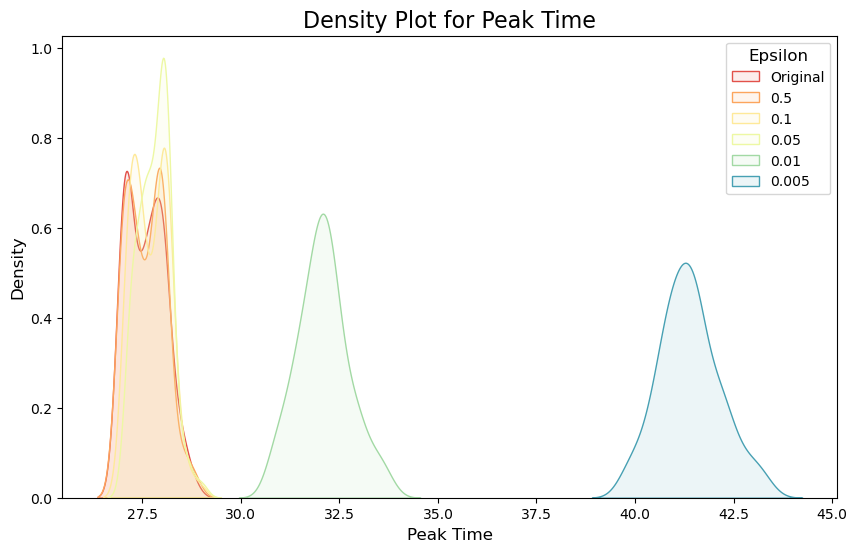

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combining data into a list of lists
data = [mean_peak_ori_agg, mean_peak_P5_agg, mean_peak_P1_agg, mean_peak_P05_agg,
        mean_peak_P01_agg, mean_peak_P005_agg]

#Labels
#labels = ['Original', '0.8', '0.5', '0.3', '0.1', '0.05', '0.01', '0.005']
labels = ['Original', '0.5', '0.1', '0.05', '0.01', '0.005']

# Generate a color palette
#color = sns.color_palette("Spectral", n_colors= 8)
color = sns.color_palette("Spectral", n_colors= 6)

# Plotting with Seaborn
plt.figure(figsize=(10, 6))

# Loop through datasets to plot their density
for i, dataset in enumerate(data):
    sns.kdeplot(dataset, label=labels[i], color=color[i], fill=True, alpha=0.1)

# Adding labels and title
plt.title("Density Plot for Peak Time", fontsize=16)
plt.xlabel("Peak Time", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Adding a legend
plt.legend(title="Epsilon", fontsize=10, title_fontsize=12)

# Save plot (optional)
#plt.savefig("peak_time_density_agg.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
